In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

In [2]:
anatree = Anatree("/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k_new.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree

In [3]:
anatree.read_parquet('../../../../../../data/atm_50k_hd_AV_2.5_random/parquet_new',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)
# merged = anatree.get_full_reco_tracks().collect()
# pl.collect_all(anatree.nu)

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [4]:
nu = anatree.nu
geant = anatree.geant
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
pfp = anatree.pfp
merged:pl.DataFrame
merged = 0
for i,n in enumerate(nu[:]):
    df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
    df = df.collect()
    if i == 0:
        merged = df
    else:
        merged = pl.concat([merged,df])

In [6]:
nu = merge_same_df(nu)
tracks = merge_same_df(tracks)
shw = merge_same_df(shw)
pfp = merge_same_df(pfp)

In [7]:
cc_numu = merged.filter(
    (pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14)
    )
n_numu_cc = len(cc_numu.groupby(selection_events()).agg())
print(f'Total events numu CC (with reconstructed track): {n_numu_cc}')
cc_numu_reco_mu = cc_numu.groupby(selection_events()).agg(
    has_mu_track = (pl.col('pdg_geant').abs() == 13).any()
)
cc_numu_reco_mu = cc_numu.join(cc_numu_reco_mu, on=selection_events(),how='inner')

Total events numu CC (with reconstructed track): 74060


In [8]:
no_mu_reco_cc_numu = cc_numu_reco_mu.filter(pl.col('has_mu_track')==0)
no_mu_reco_cc_numu_filter = no_mu_reco_cc_numu.groupby(selection_events()).agg().sort(selection_events())

dfg = 0
for i, g in enumerate(anatree.geant):
    temp = g.join(no_mu_reco_cc_numu_filter.lazy(), on=selection_events(), how='inner').collect()
    if i == 0:
        dfg = temp
    else:
        dfg = pl.concat([dfg,temp], rechunk=False)
dfg


subrun,event,pdg_geant,status_geant,Mass_geant,Eng_geant,EndE_geant,Px_geant,Py_geant,Pz_geant,P_geant,StartPointx_geant,StartPointy_geant,StartPointz_geant,StartT_geant,EndPointx_geant,EndPointy_geant,EndPointz_geant,EndT_geant,theta_geant,phi_geant,theta_xz_geant,theta_yz_geant,pathlen_geant,inTPCActive_geant,StartPointx_tpcAV_geant,StartPointy_tpcAV_geant,StartPointz_tpcAV_geant,StartT_tpcAV_geant,StartE_tpcAV_geant,StartP_tpcAV_geant,StartPx_tpcAV_geant,StartPy_tpcAV_geant,StartPz_tpcAV_geant,EndPointx_tpcAV_geant,EndPointy_tpcAV_geant,EndPointz_tpcAV_geant,EndT_tpcAV_geant,EndE_tpcAV_geant,EndP_tpcAV_geant,EndPx_tpcAV_geant,EndPy_tpcAV_geant,EndPz_tpcAV_geant,pathlen_drifted_geant,inTPCDrifted_geant,StartPointx_drifted_geant,StartPointy_drifted_geant,StartPointz_drifted_geant,StartT_drifted_geant,StartE_drifted_geant,StartP_drifted_geant,StartPx_drifted_geant,StartPy_drifted_geant,StartPz_drifted_geant,EndPointx_drifted_geant,EndPointy_drifted_geant,EndPointz_drifted_geant,EndT_drifted_geant,EndE_drifted_geant,EndP_drifted_geant,EndPx_drifted_geant,EndPy_drifted_geant,EndPz_drifted_geant,NumberDaughters_geant,Mother_geant,TrackId_geant,MergedId_geant,origin_geant,MCTruthIndex_geant,process_primary_geant,processname_geant
i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,i32,i32,str
1000,6,13,1,0.105658,1.879603,0.105658,1.875082,-0.064526,-0.040575,1.876631,85.085709,68.331596,586.057922,0.0,825.305908,37.86253,561.382446,25.136593,1.592419,-0.034399,1.592432,-2.132128,278.790588,1,85.085709,68.331596,586.057922,0.0,1.879603,1.876631,1.875082,-0.064526,-0.040575,363.376038,57.936909,574.00769,9.321409,1.263346,1.25892,1.255639,-0.063702,-0.064753,278.792084,1,85.085709,68.331596,586.057922,0.0,1.879603,1.876631,1.875082,-0.064526,-0.040575,363.377533,57.936909,574.00769,0.0,1.263346,1.25892,1.255639,-0.063702,-0.064753,15,0,1,0,1,0,1,"""primary"""
1000,6,2212,1,0.938272,0.971414,0.938272,0.058552,0.102405,-0.222207,0.251577,85.085709,68.331596,586.057922,0.0,85.328232,68.755058,585.070923,0.190598,2.653558,1.051392,2.883947,2.709751,1.101049,1,85.085709,68.331596,586.057922,0.0,0.971414,0.251577,0.058552,0.102405,-0.222207,85.328232,68.755058,585.070923,0.190598,0.938272,0.0,0.0,0.0,-0.0,1.101056,1,85.085709,68.331596,586.057922,0.0,0.971414,0.251577,0.058552,0.102405,-0.222207,85.328262,68.755058,585.070923,0.0,0.938272,0.0,0.0,0.0,-0.0,0,0,2,0,1,0,1,"""primary"""
1000,6,2212,1,0.938272,0.951522,0.938272,-0.095939,-0.075933,-0.100349,0.158241,85.085709,68.331596,586.057922,0.0,84.952156,68.236778,585.90448,0.058511,2.25771,-2.472074,-2.378656,-2.493822,0.224454,1,85.085709,68.331596,586.057922,0.0,0.951522,0.158241,-0.095939,-0.075933,-0.100349,84.952156,68.236778,585.90448,0.058511,0.938272,0.0,-0.0,0.0,-0.0,0.224449,1,85.085709,68.331596,586.057922,0.0,0.951522,0.158241,-0.095939,-0.075933,-0.100349,84.952164,68.236778,585.90448,0.0,0.938272,0.0,-0.0,0.0,-0.0,0,0,3,0,1,0,1,"""primary"""
1000,6,2212,1,0.938272,0.947056,0.938272,0.013576,-0.0891,0.091855,0.128688,85.085709,68.331596,586.057922,0.0,85.09864,68.259697,586.136108,0.033129,0.775909,-1.41959,0.146737,-0.770173,0.107028,1,85.085709,68.331596,586.057922,0.0,0.947056,0.128688,0.013576,-0.0891,0.091855,85.09864,68.259697,586.136108,0.033129,0.938272,0.0,0.0,-0.0,0.0,0.107029,1,85.085709,68.331596,586.057922,0.0,0.947056,0.128688,0.013576,-0.0891,0.091855,85.09864,68.259697,586.136108,0.0,0.938272,0.0,0.0,-0.0,0.0,0,0,4,0,1,0,1,"""primary"""
1000,6,2212,1,0.938272,0.942365,0.938272,-0.05274,0.010861,0.069262,0.087731,85.085709,68.331596,586.057922,0.0,85.067757,68.334587,586.081665,0.012401,0.660826,2.938499,-0.65079,0.155541,0.029915,1,85.085709,68.331596,586.057922,0.0,0.942365,0.087731,-0.05274,0.010861,0.069262,85.067757,68.334587,586.081665,

/tmp/ipykernel_188242/727469860.py:13: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hvals/bvals, hedges)


74699
5059


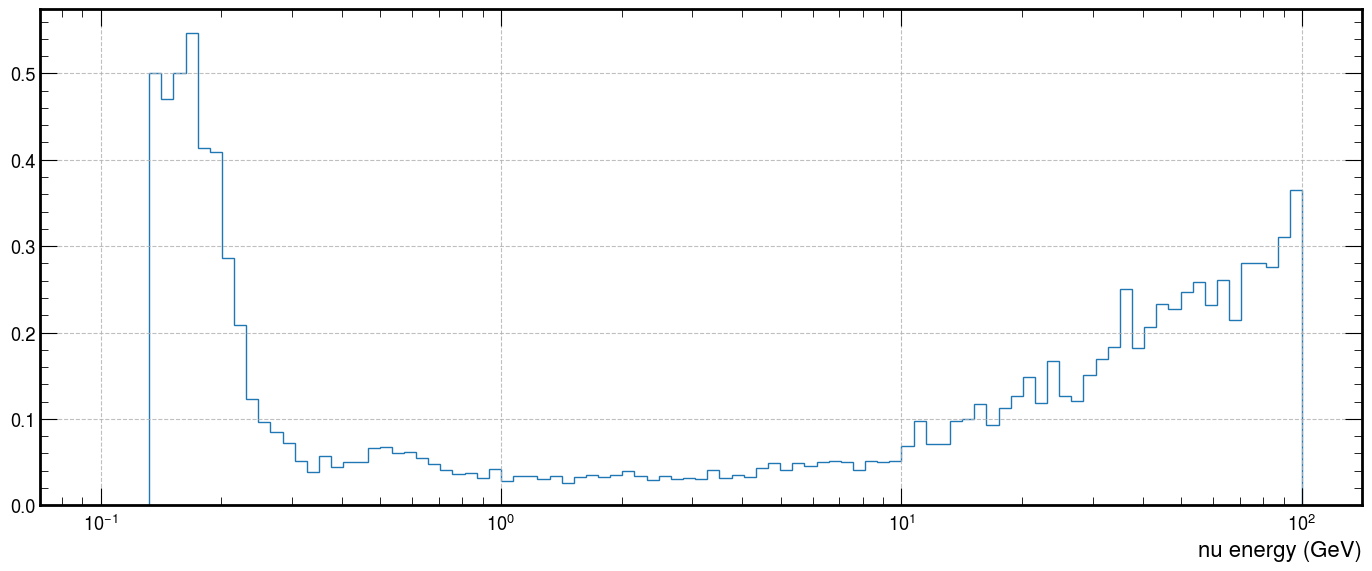

In [9]:
dfg:pl.DataFrame
unrec_mu = dfg.filter(
    (pl.col('Mother_geant')==0) & (pl.col('pdg_geant').abs()==13)
)

emin = np.log10(0.1)
emax = np.log10(100)
nbins = 100
bins = np.linspace(0.1,100,400)
bins = np.logspace(emin,emax,nbins)
bvals, bedges =  np.histogram(nu.filter(pl.col('ccnc_truth')==0).filter(pl.col('nuPDG_truth').abs()==14)['enu_truth'], bins=bins);
hvals, hedges = np.histogram(no_mu_reco_cc_numu.groupby(selection_events()).agg(pl.col('enu_truth').first())['enu_truth'], bins=bins);
plt.stairs(hvals/bvals, hedges)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('nu energy (GeV)')
print(len(nu.filter(pl.col('ccnc_truth')==0).filter(pl.col('nuPDG_truth').abs()==14)))
print(len(no_mu_reco_cc_numu.groupby(selection_events()).agg(pl.col('enu_truth').first())))

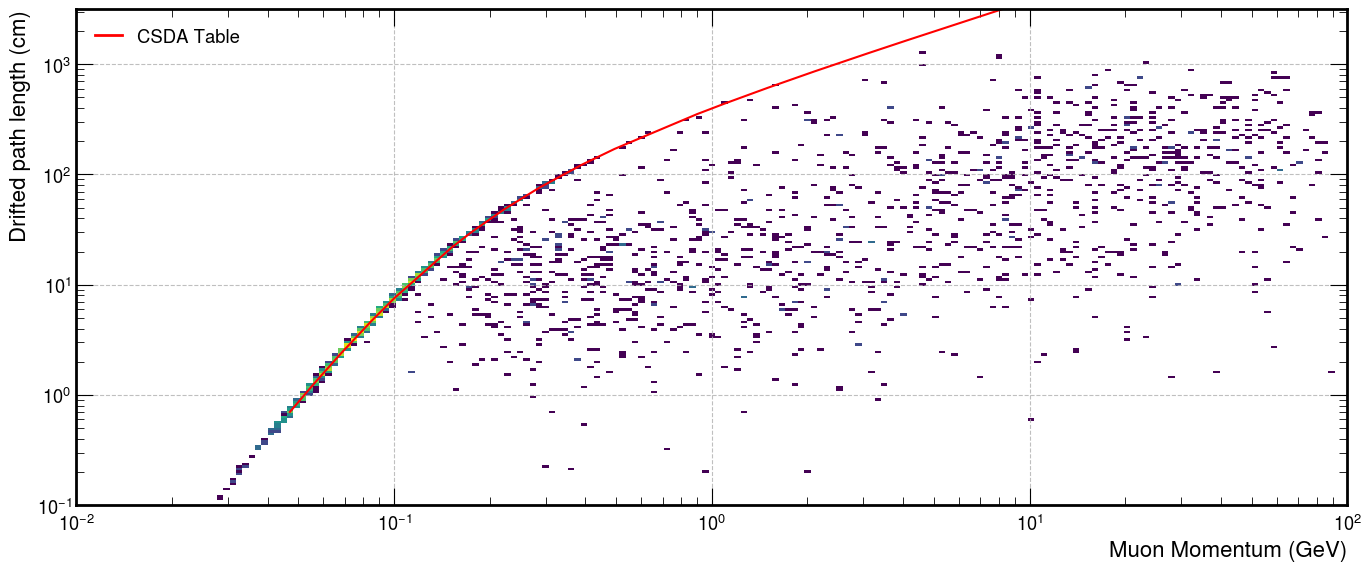

In [10]:
dftest = dfg.join(nu, on=selection_events())
q = dftest.filter(
        (pl.col("Mother_geant")==0) & (pl.col('pdg_geant').abs()==13)
).filter(
    (pl.col('Px_geant')/pl.col('P_geant')).abs() < 0.6
)
Range_grampercm = np.array([9.833E-1, 1.786E0, 3.321E0,
       6.598E0, 1.058E1, 3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
       2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3, 1.758E3, 2.297E3,
       4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4,
       4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5])
KE_MeV = np.array([ 10, 14,
       20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
       4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
       200000, 300000, 400000 ])


KE_GeV = KE_MeV/1e3
mu_mom = np.sqrt(KE_GeV*(KE_GeV+2*0.1056))
binsx=np.logspace(-2,2,200)
binsy=np.logspace(-1,3.5,200)
plt.hist2d(q['P_geant'], q['pathlen_geant'],bins=[binsx,binsy], norm=LogNorm());
plt.plot(mu_mom,Range_grampercm/1.4, c='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Muon Momentum (GeV)')
plt.ylabel('Drifted path length (cm)')
csda = [plt.Line2D([0], [0], color='red', lw=2)]
plt.legend(csda, ['CSDA Table'], loc='upper left')

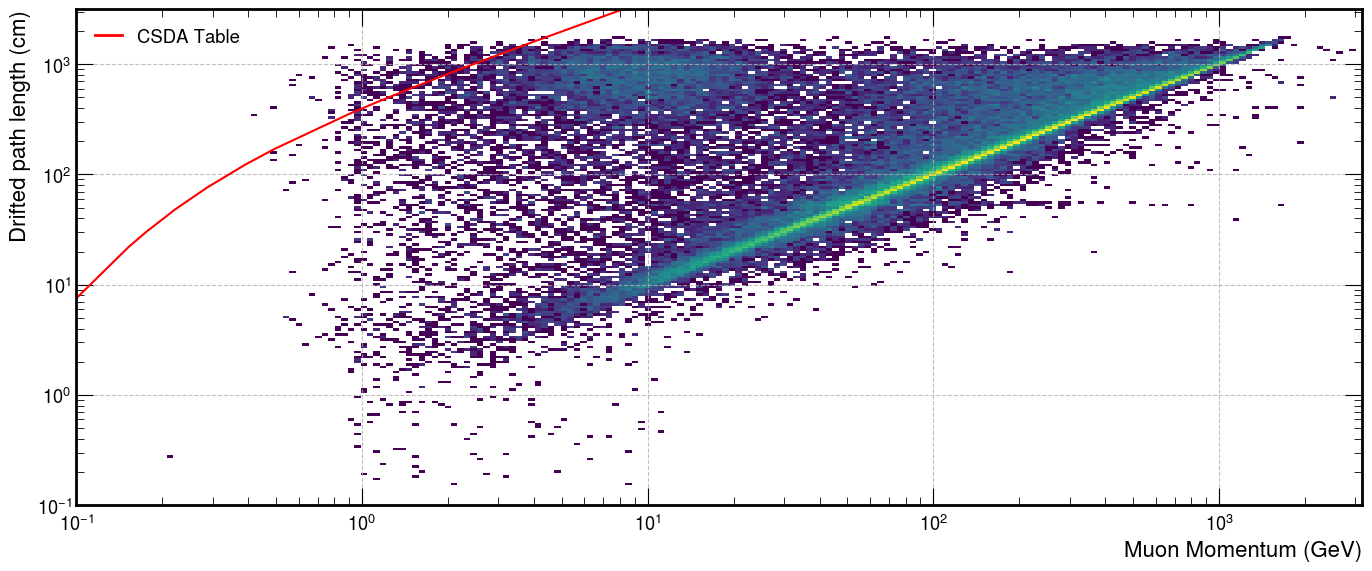

In [25]:
qrec = merged.filter(
    pl.col('pdg_geant').abs()==13
).filter(
    pl.col('has_valid_pfp')==1
)
binsx=np.logspace(-1,3.5,200)
binsy=np.logspace(-1,3.5,200)
plt.hist2d(qrec['trklen_pandoraTrack'], qrec['pathlen_drifted_geant'],bins=[binsx,binsy], norm=LogNorm());
plt.plot(mu_mom,Range_grampercm/1.4, c='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Muon Momentum (GeV)')
plt.ylabel('Drifted path length (cm)')
csda = [plt.Line2D([0], [0], color='red', lw=2)]
plt.legend(csda, ['CSDA Table'], loc='upper left')

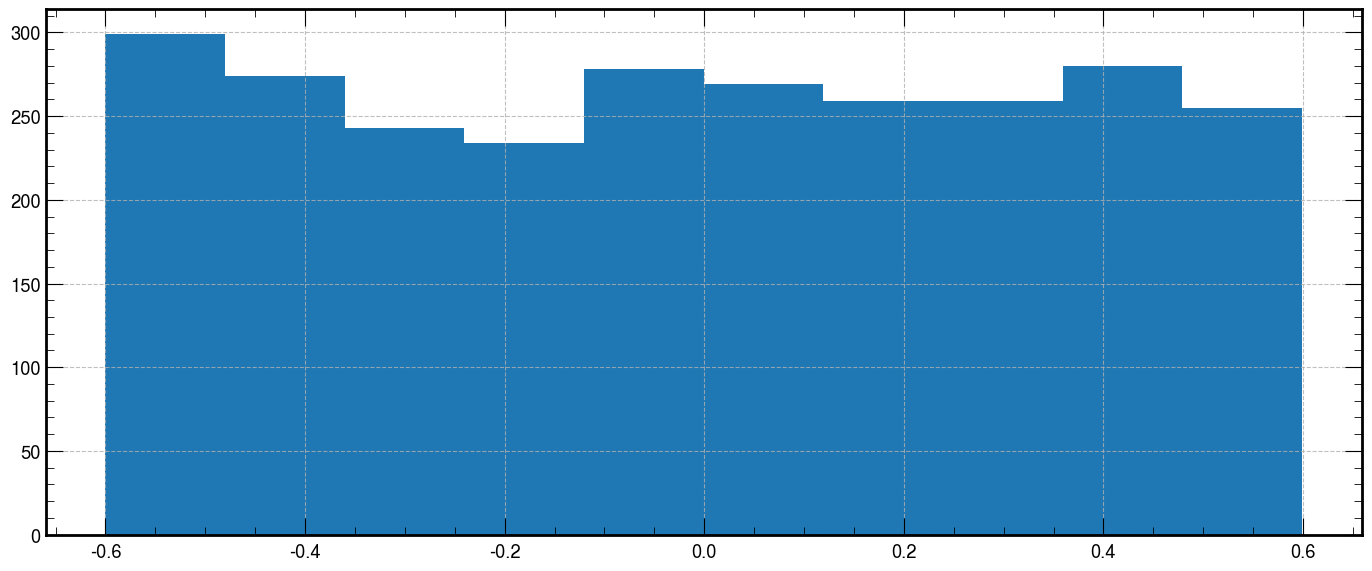

In [15]:
plt.hist(q['Px_geant']/q['P_geant']);

Text(1, 0, 'Number of reconstructed tracks and showers')

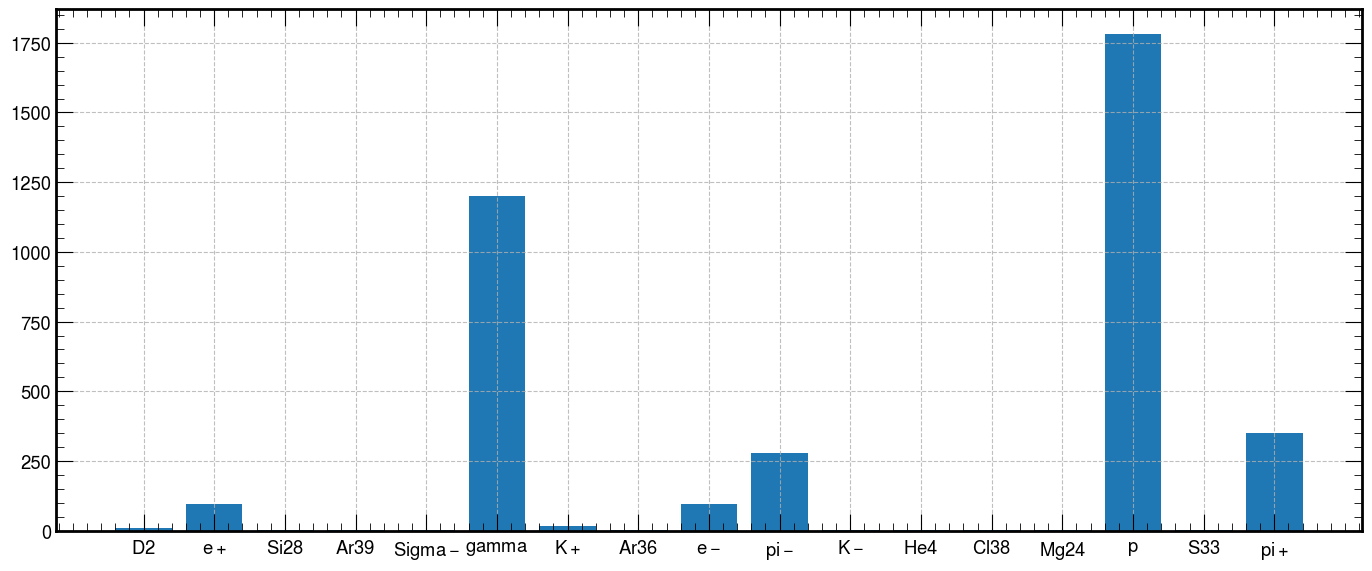

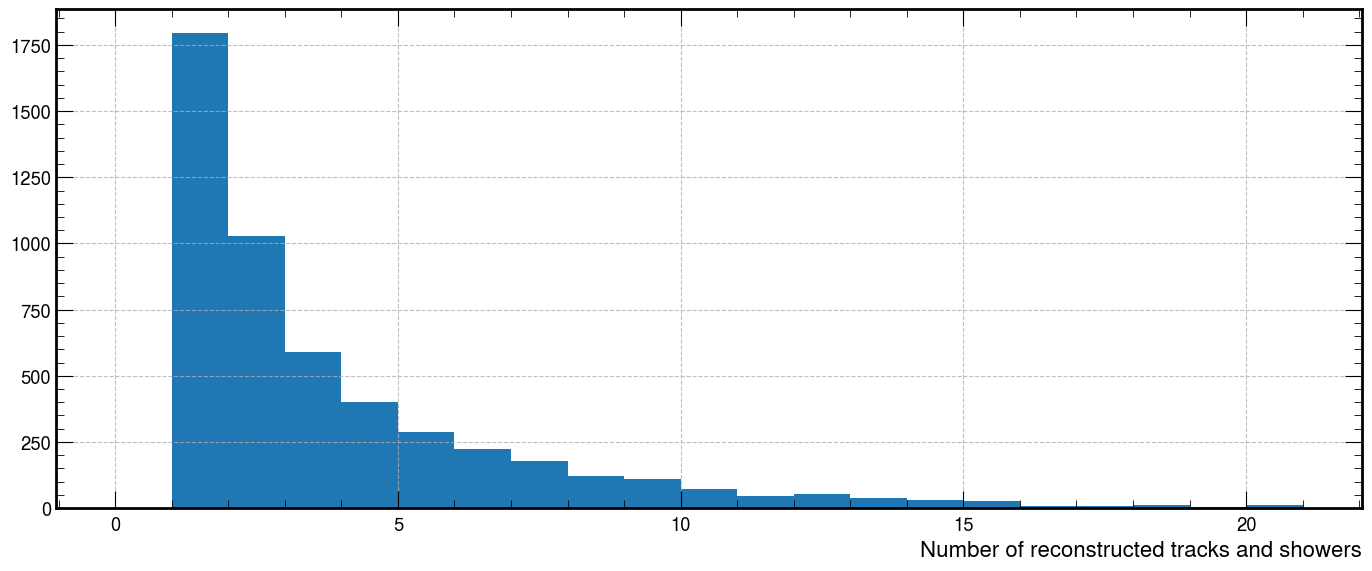

In [26]:
q_f = q.filter(
    (pl.col('pathlen_drifted_geant')>3) & (pl.col('P_geant')>0.1) & (pl.col('P_geant')<10)
).groupby(selection_events()).agg().sort(selection_events())
q_f
failed_selected_df = merged.join(q_f, on=selection_events(), how='inner')
failed_selected = failed_selected_df.groupby('pdg_geant').agg(
    entries = pl.col('pdg_geant').count()
)
pdg_names = [fr'${particle.Particle.from_pdgid(pdg)}$' for pdg in failed_selected['pdg_geant']]
total = failed_selected.select(pl.sum('entries')).to_numpy()[0][0]
plt.bar(pdg_names ,failed_selected['entries'])
plt.figure()
plt.hist(no_mu_reco_cc_numu.groupby(selection_events()).agg(pl.col('trkId_pandoraTrack').count())['trkId_pandoraTrack'], bins=np.linspace(0,21,22));
plt.xlabel('Number of reconstructed tracks and showers')

### Conclusion
Tracks missing is due to poorly association of hits to particle. Most of it are tagged as protons 


In [50]:
test_f = merged.filter(
    pl.col('trkstarty_pandoraTrack').abs() > 620
).groupby(selection_events()).agg()

test = merged.join(test_f, on=selection_events(), how='inner')
test.sort('trklen_pandoraTrack', descending=True).groupby(selection_events()).agg(
    pl.col('trklen_pandoraTrack').count().alias('nt'),
    pl.col('trklen_pandoraTrack').first()
).sort(selection_events()).filter((pl.col('nt')>1) & (pl.col('nt') <10))

subrun,event,nt,trklen_pandoraTrack
i32,i32,u32,f32
1,6,2,6.982248
100,13,6,604.680725
139,1,2,422.04718
145,17,2,335.032867
209,18,6,522.649902
271,14,3,21.071871
320,14,5,291.234772
321,13,4,476.816681
366,9,5,1121.582275
